In [17]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl

In [18]:
plt.rc ('font', size = 10) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 10) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 10) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 20) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 10) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 10) #Schriftgröße der Legende

In [19]:
def pos(x):
    for i in range(len(data[0])):
        if data[0,i]>=x:
            return i
            break

FitFunktionen

In [20]:
def gaus1fit(von,bis,path,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],data[1,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='--',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))])




def gaus2fit(von,bis,path,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(data,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],data[1,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='--',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))])

Daten einlesen und Standartfehler as Fehler der Counts festlegen

0.03788025025885551


<ErrorbarContainer object of 3 artists>

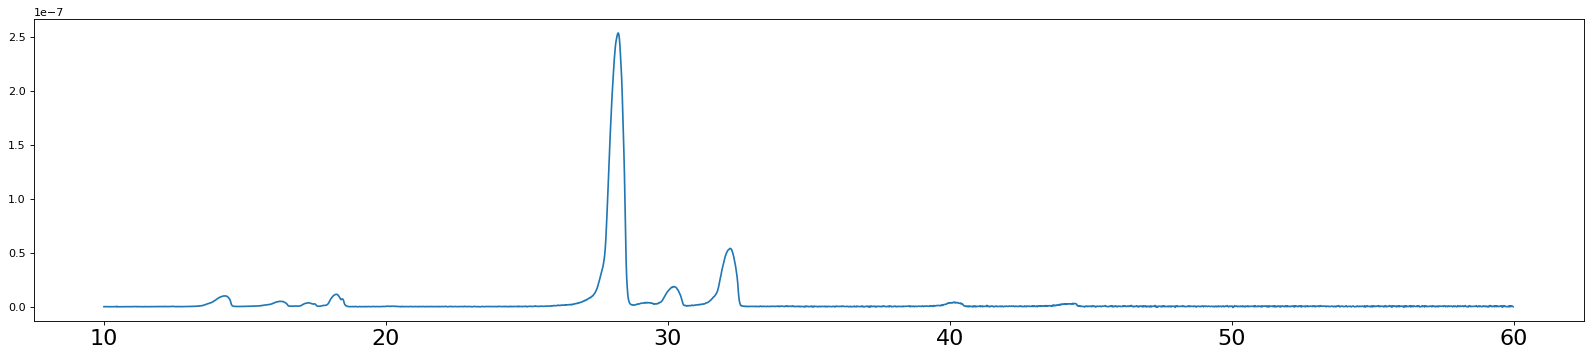

In [26]:
with open('Data/uluft_1.csv', mode='r') as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        data = np.zeros((3,len(dataex[3])))
        data[0],data[1] = dataex[3],dataex[4]

with open('Data/restgas_3.csv', mode='r') as tf:
        datarestex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        datarest = np.zeros((3,len(datarestex[3])))
        datarest[0],datarest[1] = datarestex[3],datarestex[4]




#fehlerfort data

err = list(np.zeros(len(data[1])))
for i in range(len(err)):
    err[i] = ufloat(data[1,i],float(abs(data[1,i])*0.05))




#fehlerfort rest

errrest = list(np.zeros(len(datarest[1])))
for i in range(len(errrest)):
    errrest[i] = ufloat(datarest[1,i],float(abs(datarest[1,i])*0.05))

for i in range(len(err)):
        err[i] = err[i]-errrest[i]

for i in range(len(err)):
    data[1,i]=err[i].n
    data[2,i]=err[i].s

print(data[2,1]/data[1,1])




for i in range(len(data[1])):
    data[1,i] = data[1,i]*data[0,i]/28




v = pos(10)
b = pos(60)

fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0,v:b],data[1,v:b],label = 'Data')
#plt.vlines(18.6,0,10e-9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 55
    # variables        = 3
    chi-square         = 7.1672e-17
    reduced chi-square = 1.3783e-18
    Akaike info crit   = -2258.99669
    Bayesian info crit = -2252.97469
[[Variables]]
    amplitude:  6.7336e-09 +/- 2.2795e-10 (3.39%) (init = 7.88764e-09)
    center:     14.1891562 +/- 0.01025533 (0.07%) (init = 14.2)
    sigma:      0.27347961 +/- 0.01145409 (4.19%) (init = 0.28)
    fwhm:       0.64399526 +/- 0.02697232 (4.19%) == '2.3548200*sigma'
    height:     9.8228e-09 +/- 3.0230e-10 (3.08%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.689
    C(center, sigma)     = 0.218
    C(amplitude, center) = 0.185


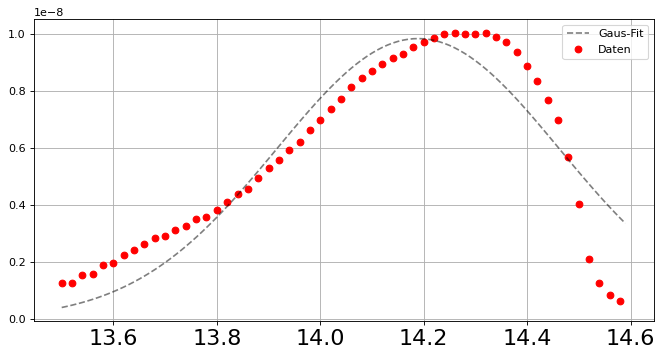

In [23]:
p14 = gaus1fit(13.5,14.6,'uluft_14.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 50
    # variables        = 3
    chi-square         = 1.4853e-17
    reduced chi-square = 3.1601e-19
    Akaike info crit   = -2127.01909
    Bayesian info crit = -2121.28303
[[Variables]]
    amplitude:  3.2520e-09 +/- 1.0983e-10 (3.38%) (init = 3.160039e-09)
    center:     16.1999741 +/- 0.00994555 (0.06%) (init = 16.22)
    sigma:      0.26864332 +/- 0.01131705 (4.21%) (init = 0.24)
    fwhm:       0.63260666 +/- 0.02664961 (4.21%) == '2.3548200*sigma'
    height:     4.8293e-09 +/- 1.4687e-10 (3.04%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.700
    C(center, sigma)     = 0.214
    C(amplitude, center) = 0.185


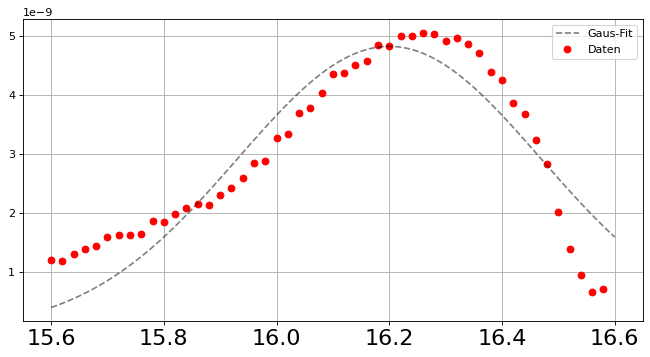

In [ ]:
p16 = gaus1fit(15.6,16.6,'uluft_16.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 35
    # variables        = 3
    chi-square         = 2.2644e-18
    reduced chi-square = 7.0763e-20
    Akaike info crit   = -1540.45957
    Bayesian info crit = -1535.79352
[[Variables]]
    amplitude:  1.7489e-09 +/- 4.2394e-11 (2.42%) (init = 2.122982e-09)
    center:     17.2644544 +/- 0.00509481 (0.03%) (init = 17.28)
    sigma:      0.19270584 +/- 0.00582968 (3.03%) (init = 0.22)
    fwhm:       0.45378756 +/- 0.01372785 (3.03%) == '2.3548200*sigma'
    height:     3.6207e-09 +/- 8.1976e-11 (2.26%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.675


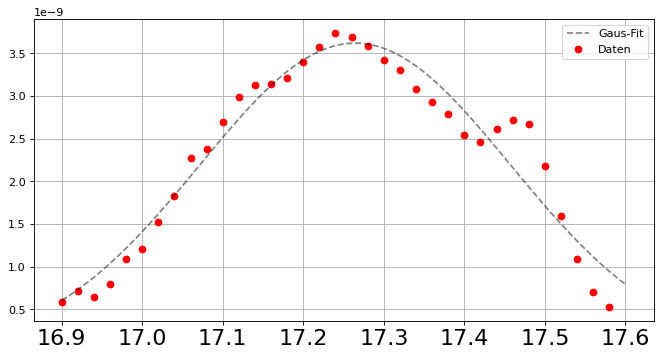

In [ ]:
p17 = gaus1fit(16.9,17.6,'uluft_17.2')

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 186
    # data points      = 59
    # variables        = 6
    chi-square         = 2.2007e-17
    reduced chi-square = 4.1522e-19
    Akaike info crit   = -2491.53031
    Bayesian info crit = -2479.06509
[[Variables]]
    g1_amplitude:  5.2955e-09 +/- 1.3349e-10 (2.52%) (init = 2.533068e-08)
    g1_center:     18.2353662 +/- 0.00482075 (0.03%) (init = 18.21)
    g1_sigma:      0.18209544 +/- 0.00489020 (2.69%) (init = 0.23)
    g2_amplitude:  3.3781e-09 +/- 7.5944e-08 (2248.12%) (init = 7.599203e-09)
    g2_center:     17.0000009 +/- 5.97292601 (35.13%) (init = 17.21)
    g2_sigma:      0.32281282 +/- 1.54278029 (477.92%) (init = 0.9)
    g1_fwhm:       0.42880199 +/- 0.01151554 (2.69%) == '2.3548200*g1_sigma'
    g1_height:     1.1602e-08 +/- 1.9873e-10 (1.71%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.7

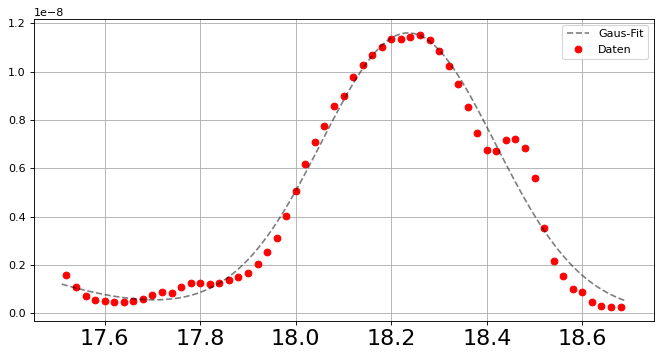

In [ ]:
p18 = gaus2fit(17.51,18.7,'uluft_18.2',override=True,m1=18.21,m1min=18,m1max=18.5,s1=0.23,scale1=2.533068e-08,m2=17.21,m2min=17,m2max=17.5,s2=0.9,scale2=7.599203e-09)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 100
    # variables        = 3
    chi-square         = 2.2298e-14
    reduced chi-square = 2.2987e-16
    Akaike info crit   = -3597.94585
    Bayesian info crit = -3590.13034
[[Variables]]
    amplitude:  1.4291e-07 +/- 2.3098e-09 (1.62%) (init = 1.965575e-07)
    center:     28.1777274 +/- 0.00407288 (0.01%) (init = 28.18)
    sigma:      0.21823226 +/- 0.00407291 (1.87%) (init = 0.26)
    fwhm:       0.51389770 +/- 0.00959097 (1.87%) == '2.3548200*sigma'
    height:     2.6125e-07 +/- 4.2224e-09 (1.62%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


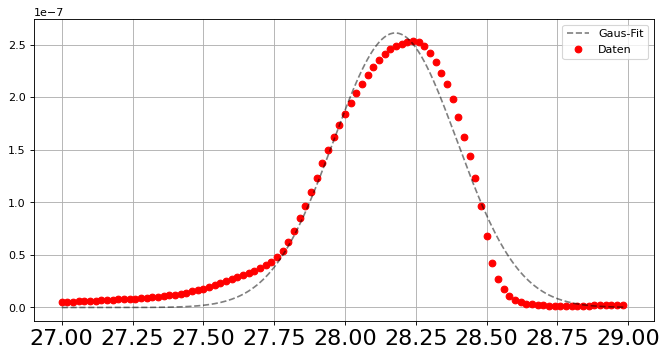

In [ ]:
p28 = gaus1fit(27,29,'uluft_28.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 35
    # variables        = 3
    chi-square         = 5.5585e-19
    reduced chi-square = 1.7370e-20
    Akaike info crit   = -1589.61971
    Bayesian info crit = -1584.95367
[[Variables]]
    amplitude:  3.2042e-09 +/- 7.0972e-11 (2.21%) (init = 1.644668e-09)
    center:     29.2562444 +/- 0.00639923 (0.02%) (init = 29.25)
    sigma:      0.33794081 +/- 0.00880863 (2.61%) (init = 0.23)
    fwhm:       0.79578978 +/- 0.02074274 (2.61%) == '2.3548200*sigma'
    height:     3.7825e-09 +/- 3.4334e-11 (0.91%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.942
    C(amplitude, center) = 0.707
    C(center, sigma)     = 0.669


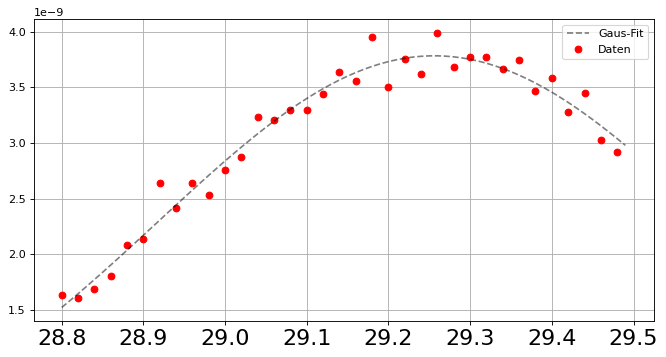

In [ ]:
p29 = gaus1fit(28.8,29.5,'uluft_29.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 55
    # variables        = 3
    chi-square         = 9.4997e-17
    reduced chi-square = 1.8269e-18
    Akaike info crit   = -2243.50128
    Bayesian info crit = -2237.47928
[[Variables]]
    amplitude:  1.1437e-08 +/- 2.3027e-10 (2.01%) (init = 1.410767e-08)
    center:     30.1694074 +/- 0.00548706 (0.02%) (init = 30.17)
    sigma:      0.24206759 +/- 0.00589401 (2.43%) (init = 0.27)
    fwhm:       0.57002561 +/- 0.01387932 (2.43%) == '2.3548200*sigma'
    height:     1.8849e-08 +/- 3.6492e-10 (1.94%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.636
    C(center, sigma)    = 0.109


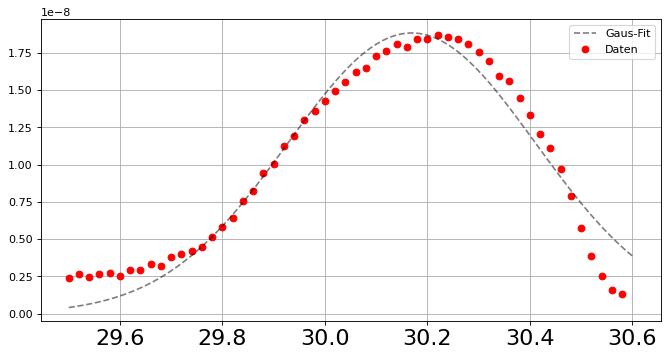

In [ ]:
p30 = gaus1fit(29.5,30.6,'uluft_30.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 65
    # variables        = 3
    chi-square         = 1.1148e-15
    reduced chi-square = 1.7980e-17
    Akaike info crit   = -2503.29449
    Bayesian info crit = -2496.77133
[[Variables]]
    amplitude:  3.2711e-08 +/- 6.7131e-10 (2.05%) (init = 4.52243e-08)
    center:     32.1535558 +/- 0.00554646 (0.02%) (init = 32.16)
    sigma:      0.23447247 +/- 0.00557606 (2.38%) (init = 0.28)
    fwhm:       0.55214046 +/- 0.01313061 (2.38%) == '2.3548200*sigma'
    height:     5.5656e-08 +/- 1.1411e-09 (2.05%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.580


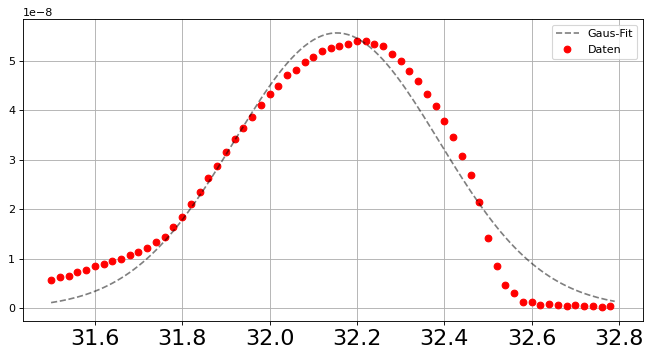

In [ ]:
p32 = gaus1fit(31.5,32.8,'uluft_32.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 55
    # variables        = 3
    chi-square         = 8.2056e-18
    reduced chi-square = 1.5780e-19
    Akaike info crit   = -2378.19783
    Bayesian info crit = -2372.17583
[[Variables]]
    amplitude:  2.8659e-09 +/- 7.6204e-11 (2.66%) (init = 3.419452e-09)
    center:     40.1250970 +/- 0.00839266 (0.02%) (init = 40.15)
    sigma:      0.28543669 +/- 0.00937146 (3.28%) (init = 0.29)
    fwhm:       0.67215202 +/- 0.02206809 (3.28%) == '2.3548200*sigma'
    height:     4.0055e-09 +/- 9.9929e-11 (2.49%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.666
    C(center, sigma)     = 0.128
    C(amplitude, center) = 0.105


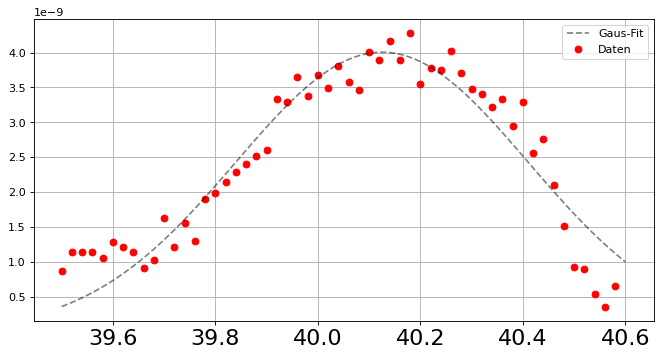

In [ ]:
p40 = gaus1fit(39.5,40.6,'uluft_40.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 100
    # variables        = 3
    chi-square         = 2.0278e-17
    reduced chi-square = 2.0905e-19
    Akaike info crit   = -4298.21886
    Bayesian info crit = -4290.40335
[[Variables]]
    amplitude:  2.4669e-09 +/- 9.1223e-11 (3.70%) (init = 4.187056e-09)
    center:     44.1501970 +/- 0.01558502 (0.04%) (init = 44.13676)
    sigma:      0.36709631 +/- 0.01585360 (4.32%) (init = 0.42)
    fwhm:       0.86444574 +/- 0.03733237 (4.32%) == '2.3548200*sigma'
    height:     2.6809e-09 +/- 9.8662e-11 (3.68%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.588


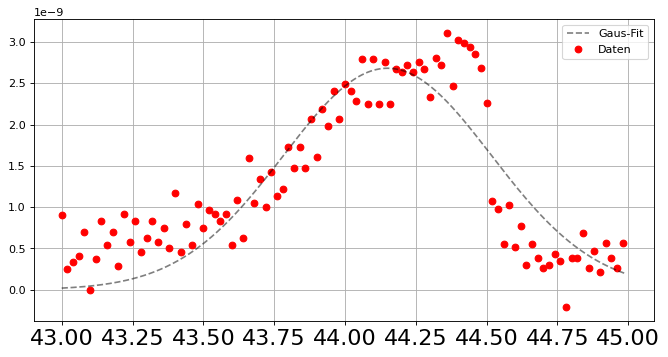

In [ ]:
p44 = gaus1fit(43,45,'uluft_44.2')

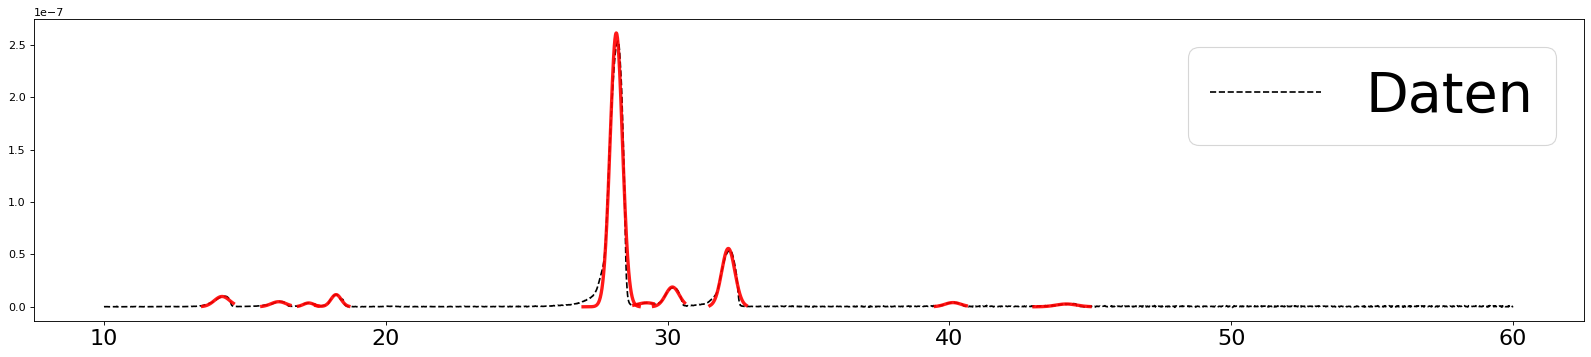

In [ ]:
fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0],data[1],zorder=5,mfc='black',color='k',linestyle='--',label='Daten')

plt.plot(p14[0],p14[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p16[0],p16[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p17[0],p17[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p18[0],p18[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p28[0],p28[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p29[0],p29[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p30[0],p30[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p32[0],p32[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p40[0],p40[1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p44[0],p44[1],zorder=10,color='r',alpha=0.9,linewidth=3)


plt.legend(fontsize=50)